# model_training_&_validation.ipynb

## Purpose
Train and validate six different classification models on the provided handwriting digit training dataset.  
Hyperparameters are tuned using training/validation procedures, and model performance is compared across all methods.

## Inputs
- **project_1_training.csv**  
  Labeled digit image data used for training and validation.

## Outputs
- Trained versions of all six classification models with selected hyperparameters  
- A comparison figure showing training/validation accuracy for all models  
- Saved model objects (used later in `model_testing.ipynb`)  
- Identification of the best-performing model for final test prediction

## Import Data

In [5]:
import pandas as pd

train_df = pd.read_csv("training.csv")
print(train_df.shape)
train_df.head()

(21000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## inspect missingness

In [6]:
train_df.isnull().sum().sum()

# No missing values were found in the training dataset.
# All pixel features are fully observed.

np.int64(0)

## check pixel range

In [ ]:
y = train_df["label"]
X = train_df.drop(columns=["label"])

print(X.min().min(), X.max().max())

# Pixel intensity values are within the expected grayscale range (0–255),
# so no additional cleaning or correction is needed.

0 255
0    4
1    7
2    3
3    7
4    5
Name: label, dtype: int64


## drop constant features 

In [8]:
import numpy as np

print("Checking for constant features...\n")

# Calculate variance of each feature
variances = X.var()

# Identify constant features (variance == 0)
constant_features = variances[variances == 0].index.tolist()

num_constant = len(constant_features)

print(f"Total features before dropping: {X.shape[1]}")
print(f"Number of constant features found: {num_constant}")

if num_constant > 0:
    print("\nDropping constant features...")
    X = X.drop(columns=constant_features)
else:
    print("\nNo constant features found.")

print(f"\nTotal features after dropping: {X.shape[1]}")
print("Done.")

Checking for constant features...

Total features before dropping: 784
Number of constant features found: 89

Dropping constant features...

Total features after dropping: 695
Done.


## kNN Training and validation

kNN Cross-Validation Sweep
Candidate k values: [1, 3, 5, 7, 9, 11]
CV strategy: StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Distance metric: Euclidean (metric='minkowski', p=2) [default]
Weights: uniform
Preprocessing: StandardScaler() inside Pipeline (prevents leakage)
Scoring metric: accuracy

[k= 1] CV accuracy = 0.9248 ± 0.0025
[k= 3] CV accuracy = 0.9268 ± 0.0018
[k= 5] CV accuracy = 0.9270 ± 0.0023
[k= 7] CV accuracy = 0.9250 ± 0.0041
[k= 9] CV accuracy = 0.9221 ± 0.0038
[k=11] CV accuracy = 0.9193 ± 0.0026

Sweep complete.

Best hyperparameter choice based on mean CV accuracy:
  -> best_k = 5
  -> CV accuracy = 0.9270 ± 0.0023



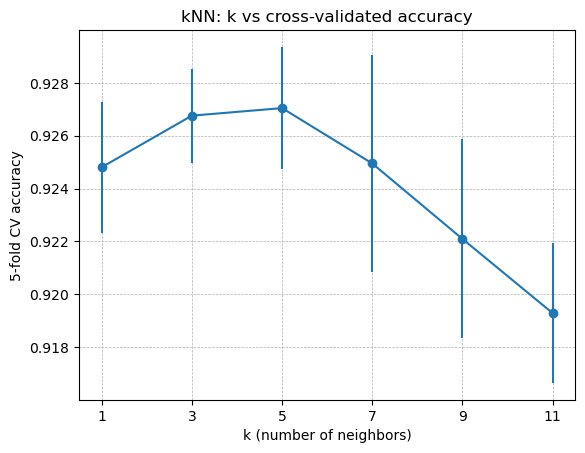

Fitting best model on the full training data...
Done.

Saved best model object
Path: best_knn_model.joblib
Model: Pipeline(StandardScaler -> KNeighborsClassifier)
Chosen k: 5
Weights: uniform


In [9]:
# KNN (k = 1..11 odd) + 5-fold CV, plot k vs accuracy, pick best, refit, and save model

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone
import joblib


# -----------------------------
# Settings
# -----------------------------
k_values = list(range(1, 12, 2))  # 1,3,5,7,9,11
cv_folds = 5
random_state = 42
use_distance_weights = False  # set True if you want weights='distance'

weights_mode = "distance" if use_distance_weights else "uniform"

print("==============================================")
print("kNN Cross-Validation Sweep")
print("==============================================")
print(f"Candidate k values: {k_values}")
print(f"CV strategy: StratifiedKFold(n_splits={cv_folds}, shuffle=True, random_state={random_state})")
print(f"Distance metric: Euclidean (metric='minkowski', p=2) [default]")
print(f"Weights: {weights_mode}")
print("Preprocessing: StandardScaler() inside Pipeline (prevents leakage)")
print("Scoring metric: accuracy")
print("==============================================\n")


# -----------------------------
# Build pipeline template
# -----------------------------
knn_pipeline_template = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(weights=weights_mode, n_jobs=-1))
])

cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

# -----------------------------
# Run CV sweep over k
# -----------------------------
results = []  # list of dicts: {'k':..., 'mean':..., 'std':...}

for k in k_values:
    model = clone(knn_pipeline_template)
    model.set_params(knn__n_neighbors=k)

    scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

    mean_acc = scores.mean()
    std_acc = scores.std()

    results.append({"k": k, "mean_acc": mean_acc, "std_acc": std_acc})

    print(f"[k={k:2d}] CV accuracy = {mean_acc:.4f} ± {std_acc:.4f}")

print("\n==============================================")
print("Sweep complete.")
print("==============================================\n")


# -----------------------------
# Pick best k (highest mean CV accuracy)
# Tie-breaker: choose smaller k (more conservative) if means are equal
# -----------------------------
best = sorted(results, key=lambda d: (-d["mean_acc"], d["k"]))[0]
best_k = best["k"]
best_mean = best["mean_acc"]
best_std = best["std_acc"]

print("Best hyperparameter choice based on mean CV accuracy:")
print(f"  -> best_k = {best_k}")
print(f"  -> CV accuracy = {best_mean:.4f} ± {best_std:.4f}\n")


# -----------------------------
# Plot: k vs CV accuracy (with error bars)
# -----------------------------
ks = [r["k"] for r in results]
means = [r["mean_acc"] for r in results]
stds = [r["std_acc"] for r in results]

plt.figure()
plt.errorbar(ks, means, yerr=stds, fmt='o-')
plt.xticks(ks)
plt.xlabel("k (number of neighbors)")
plt.ylabel("5-fold CV accuracy")
plt.title("kNN: k vs cross-validated accuracy")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


# -----------------------------
# Refit best model on ALL training data and save it
# -----------------------------
best_model = clone(knn_pipeline_template)
best_model.set_params(knn__n_neighbors=best_k)

print("Fitting best model on the full training data...")
best_model.fit(X, y)
print("Done.\n")

model_path = "best_knn_model.joblib"
joblib.dump(best_model, model_path)

print("==============================================")
print("Saved best model object")
print("==============================================")
print(f"Path: {model_path}")
print(f"Model: Pipeline(StandardScaler -> KNeighborsClassifier)")
print(f"Chosen k: {best_k}")
print(f"Weights: {weights_mode}")
print("==============================================")